## 频域分析_先进行频域计算,然后再叠加平均

In [1]:
'''

单个被试进行分析
先画出4hz FTR看看

18s的刺激长度

注意：4Hz 这些低频的信号 时间窗要
'''



'\n\n单个被试进行分析\n先画出4hz FTR看看\n\n18s的刺激长度\n\n注意：4Hz 这些低频的信号 时间窗要\n'

In [2]:
import  mne
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np


In [2]:

#E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_ASSR\pre4008_y_4Hz_-epo.fif

data_path = 'E:\Python LYW\RSA\spaced_learning\pre10\\analysis\data\\6epoch_clean_ASSR\\'
sub_ids = [
            'pre4008_y'
          ]

sub_id = sub_ids[0]
# 修改合适的epoch地址
epochs_all = mne.read_epochs(data_path+sub_id+'_4Hz_-epo.fif')
epochs_4Hz = epochs_all['4']
# #6Hz的情况
# epochs_all = mne.read_epochs(data_path+sub_id+'_6hz-epo.fif')
# epochs_4Hz = epochs_all['6']

Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_ASSR\pre4008_y_4Hz_-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...   31000.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


In [15]:
# epochs_4Hz = mne.read_epochs(data_path+sub_id+'_4Hz-epo.fif')
# 考虑是否应该避开10Hz，直接高通或者低通去掉
# epochs_4Hz = epochs_4Hz.copy().filter(0,7)

In [16]:
# epochs_4Hz.plot_psd(fmin=15.,fmax=50.,average=True,spatial_colors=False)

#问题：
ASSR的全channel的PSD图和其他的不一样？--参考MNE（https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py）
这是因为什么呢？

4Hz到底有没有ASSR看不出来，

In [3]:
'''
问题：
1 需要分析哪个channel？
2 PSD 和 SNR 都需要试试
'''

# epochs_4Hz.plot_sensors(show_names=True)
'''
根据mne分析VSSR的脚本
https://mne.tools/stable/auto_tutorials/time-freq/50_ssvep.html?highlight=snr

'''
tmin = 0.
tmax = 31
fmin = 0.
fmax = 15
sfreq = epochs_4Hz.info['sfreq']
# channels = ['T7','M2','M1','Cz','T8']
channels = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6','FT7','FT8']
channels = ['FCz','FC1','FC2','Fz','F1','F2','Cz','C1','C2']
# psds = epochs_4Hz.compute_psd(
#     method='multitaper',
#     picks=channels,
#     n_fft=int(sfreq * (tmax - tmin)),
#     n_overlap=0, n_per_seg=None,
#     average='median',
#     tmin=tmin, tmax=tmax,
#     fmin=fmin, fmax=fmax,
#     window='boxcar',
#     verbose=False)

psds, freqs = mne.time_frequency.psd_welch(
    #关键设置 4 还是 30
    epochs_4Hz,
    picks = channels,
    n_fft=int(sfreq * (tmax - tmin)),
    # n_fft= 1000,
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False,
    average = 'mean'
    )

def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=5,
                    noise_skip_neighbor_freqs=1)

<decorator-gen-201>:4: FutureWarning: NOTE: psd_welch() is a deprecated function. Function psd_welch() is deprecated; for Raw/Epochs/Evoked instances use spectrum = instance.compute_psd(method="welch") instead, followed by spectrum.get_data(return_freqs=True)..


In [4]:
%matplotlib qt

fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
#填充阴影
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]
# 作图保持一致
axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])

#增加横坐标刻度
plt.xticks(np.arange(fmin, fmax, 1.0))
fig.show()


In [20]:
axes[1].plot(freqs[freq_range], snr_mean, color='r')
fig.show()


In [11]:
'''
接着看一下时频分析情况
https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py
'''
# freqs = np.logspace(*np.log10([1, 50]), num=8)
freqs = np.linspace(start=1, stop=20, num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
# power的数据结构（62channel，20freq， 6234个时间点）  查看times是从-0.5 -0.497 -0.494 …… 18.199，刚好是decim，每个时间点上都有power值！
power, itc = tfr_morlet(epochs_4Hz, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=1, n_jobs=3)

[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    6.4s
[Parallel(n_jobs=3)]: Done  62 out of  62 | elapsed:   20.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done  62 out of  62 | elapsed:   18.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done  62 out of  62 | elapsed:   18.3s finished


In [12]:
%matplotlib qt
power.plot_topo(baseline=[-0.5, 0], title='Average power', mode='mean', colorbar = True)
# power.plot([33], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[33])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
#画那个频段的 alpha Beta  地形图 === 地形图怎么看呢？
# power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
#                    baseline=(-0.5, 0), mode='logratio', axes=axis[0],
#                    title='Alpha', show=False)
# power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
#                    baseline=(-0.5, 0), mode='logratio', axes=axis[1],
#                    title='Beta', show=False)
# power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=1, fmax=20,
#                    baseline=(-0.5, 0), mode='ratio', axes=axis[1],
#                    title='all freq', show=False,vmin=0., vmax=1., cmap='Reds')
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: mean)


In [40]:
np.min(power.data)


5.7595542333809556e-11

In [41]:
np.max(power.data)

4.898874786675654e-08

Applying baseline correction (mode: mean)


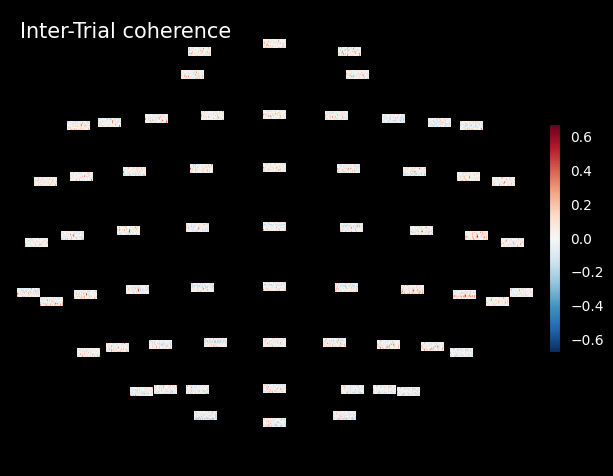

In [26]:
itc.plot_topo(baseline=[-0.5,0], tmin=0, tmax=16, title='Inter-Trial coherence', colorbar=True)


In [16]:
np.min(itc.data)

3.448421231246559e-05

In [52]:
'''

借鉴
Popov, T., Oostenveld, R., & Schoffelen, J. M. (2018). FieldTrip Made Easy: An Analysis Protocol for Group Analysis of the Auditory Steady State Brain Response in Time, Frequency, and Space. Frontiers in Neuroscience, 12. https://www.frontiersin.org/article/10.3389/fnins.2018.00711

对power进行   before/ active 比较。

'''


'\n\n借鉴\nPopov, T., Oostenveld, R., & Schoffelen, J. M. (2018). FieldTrip Made Easy: An Analysis Protocol for Group Analysis of the Auditory Steady State Brain Response in Time, Frequency, and Space. Frontiers in Neuroscience, 12. https://www.frontiersin.org/article/10.3389/fnins.2018.00711\n\n对power进行   before/ active 比较。\n\n'

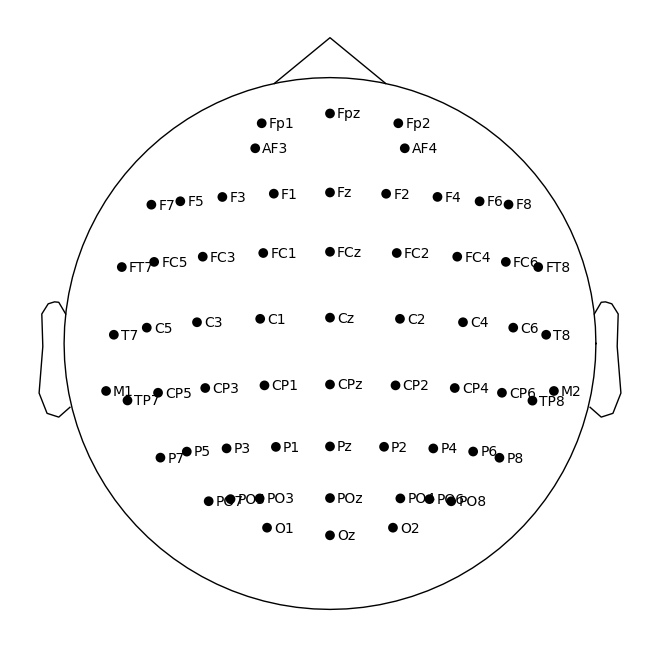

In [53]:
epochs_4Hz.plot_sensors(show_names=True)


In [54]:
'''
https://mne.tools/stable/auto_tutorials/time-freq/50_ssvep.html
'''
# define stimulation frequency
stim_freq = 30.
# find index of frequency bin closest to stimulation frequency
# freqs是频率的数列，找出最接近30的频率对应的indice。
i_bin_30hz = np.argmin(abs(freqs - stim_freq))
# could be updated to support multiple frequencies

# for later, we will already find the 15 Hz bin and the 1st and 2nd harmonic
# for both.
# i_bin_24hz = np.argmin(abs(freqs - 24))
# i_bin_36hz = np.argmin(abs(freqs - 36))
# i_bin_15hz = np.argmin(abs(freqs - 15))
# i_bin_30hz = np.argmin(abs(freqs - 30))
# i_bin_45hz = np.argmin(abs(freqs - 45))
# Define different ROIs
# roi_aud = ['M1', 'T7', 'TP7', 'C5', 'CP5', 'FT7', 'FC5',
#            'P7', 'P5','M2', 'T8', 'TP8', 'C6', 'CP6', 'FT8', 'FC6',
#            'P8', 'P6']  # auditory  roi
roi_aud = ['M1', 'T7', 'TP7', 'C5', 'CP5', 'FT7', 'FC5',
           'P7', 'P5']
# Find corresponding indices using mne.pick_types()
picks_roi_aud = mne.pick_types(epochs_4Hz.info, eeg=True, stim=False,
                               exclude='bads', selection=roi_aud)

In [55]:
snrs_target = snrs[:, :, i_bin_30hz][:, picks_roi_aud]
print("sub 2, 12 Hz trials, SNR at 12 Hz")
# print(f'average SNR (occipital ROI): {snrs_target.mean()}')
print(f'average SNR (occipital ROI): {snrs_target}')
'''
问题是怎么做统计呢？ snrs_target 的数据结构是  试次 *  channel，
我需要先平均了channel
然后来统计试次

和谁比？和0比较吗？需要证明显著大于0
'''
# 在channel的维度做平均
snrs_target_meanchan = snrs_target.mean(axis=1)
# 测试其平均值是不是高于0

sub 2, 12 Hz trials, SNR at 12 Hz
average SNR (occipital ROI): [[3.72185954e-01 3.39655913e-01 3.37662171e-02 3.25890063e-02
  8.97324037e-02 2.47103087e-01 2.48414734e-02 4.30892435e-01
  1.56409946e-01]
 [2.84393961e+00 3.92126523e+00 3.87488129e+00 2.31250581e+00
  3.18323734e-01 2.94199929e+00 1.52747017e+00 2.67431198e+00
  4.30843341e-01]
 [2.70949906e+00 1.14966260e+00 4.76933749e+00 1.89609703e+00
  1.06162910e+00 5.10798397e+00 2.12519485e-01 3.78802261e+00
  5.40476303e-01]
 [7.81107195e-01 1.28291997e+00 4.98199587e+00 2.51671720e+00
  7.71323008e-01 3.87571286e+00 2.22706381e+00 4.66137383e+00
  1.39119987e+00]
 [3.58053436e-02 7.41506968e-01 9.81348391e-02 5.75318220e-01
  8.61349529e-02 2.35476533e-01 5.54813044e-01 5.07424047e-01
  2.52788093e-01]
 [1.69464174e+01 1.96029886e+00 1.60573741e+01 2.98278002e+00
  1.13004569e+00 6.14277723e+00 1.08011933e+00 3.52557810e+00
  7.97154727e-01]
 [1.11701025e+00 1.00214893e+00 1.46388217e+00 1.67763046e-01
  1.26044213e+00 1.7135

In [56]:
from scipy import  stats
t, p = stats.ttest_1samp(snrs_target_meanchan,popmean=0,alternative='greater')

## 频域分析_先叠加平均,再计算频域

还有另一种思路是先拼接(延长试次),再求频域